In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.stats as st
import seaborn.objects as so
import seaborn as sns

In [2]:
palette = ['#7a5195', '#ef5675', '#ffa600'] #https://matplotlib.org/stable/gallery/color/named_colors.html
marker_size = 8  # Ustalony rozmiar markerów
xlabel = "Distance beetwen AP and STAs [m]"

In [3]:
data = pd.read_csv('MLOn215.csv').drop_duplicates()
data

,rngRun,flow,nStations,distance,linksNumber,loss,jitter,latency,throughput,rxBytes,...,txPackets,timeFirstRxPacket,timeFirstTxPacket,timeLastRxPacket,timeLastTxPacket,jitterSum,delaySum,rateAdaptationManager,scenario,MLOn
0,407456,1,1,15,2,90.1323,0.001719,3.18622,10.5631,166069152,...,1101413,1.04126,1.04126,120.988,120.988,186.856,346291.0,ns3::ThompsonSamplingWifiManager,C,0
1,407456,2,1,15,2,88.6797,0.001502,3.03889,12.1282,190515624,...,1101413,1.01639,1.01639,120.863,120.863,187.289,378898.0,ns3::ThompsonSamplingWifiManager,C,0
2,407456,3,1,15,2,88.3781,0.001462,3.17484,12.5517,195591640,...,1101413,2.10276,2.10276,120.991,120.991,187.131,406396.0,ns3::ThompsonSamplingWifiManager,C,0
3,407456,4,1,15,2,89.2186,0.001584,3.18184,11.5602,181446944,...,1101413,1.24937,1.24937,120.999,120.999,188.080,377837.0,ns3::ThompsonSamplingWifiManager,C,0
4,407456,5,1,15,2,88.2771,0.001456,3.13516,12.5478,197292304,...,1101413,1.01440,1.01440,120.973,120.973,187.958,404806.0,ns3::ThompsonSamplingWifiManager,C,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,407461,2,1,15,2,86.4483,0.001345,2.98781,14.5119,228069280,...,1101413,1.04840,1.04840,120.952,120.952,200.779,445960.0,ns3::ThompsonSamplingWifiManager,D,1
380,407461,3,1,15,2,85.9254,0.001242,2.98270,15.0626,236870560,...,1101413,1.01103,1.01103,120.989,120.989,192.504,462379.0,ns3::ThompsonSamplingWifiManager,D,1
381,407461,4,1,15,2,86.8325,0.001310,2.97354,14.0952,221604312,...,1101413,1.02315,1.02315,120.972,120.972,189.987,431249.0,ns3::ThompsonSamplingWifiManager,D,1
382,407461,5,1,15,2,86.4512,0.001273,2.98879,14.6234,228020384,...,1101413,2.03597,2.03597,121.000,121.000,189.932,446011.0,ns3::ThompsonSamplingWifiManager,D,1


In [4]:
# Utwórz kolumny logiczne
data = data.copy()
data['flow_leq_MLOn'] = data['flow'] <= data['MLOn']
data['flow_gt_MLOn'] = data['flow'] > data['MLOn']

In [5]:
df0 = (
    data[data['flow_leq_MLOn']]
    .groupby(['scenario', 'distance', 'linksNumber', 'rngRun', 'MLOn'], as_index=False)
    .mean(numeric_only=True)
    .assign(flow='≤MLOn')
)

df1 = (
    data[data['flow_gt_MLOn']]
    .groupby(['scenario', 'distance', 'linksNumber', 'rngRun', 'MLOn'], as_index=False)
    .mean(numeric_only=True)
    .assign(flow='>MLOn')
)

#  Suma flow 0 + 1
df_sum = (
    data
        .groupby(['scenario', 'distance', 'linksNumber', 'rngRun', 'MLOn'], as_index=False)
        .mean(numeric_only=True)
        .assign(flow='1+2')                       # sztuczna etykieta – tylko żeby było wiadomo
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_56552\768222247.py:26: UserWarning: Mismatched number of handles and labels: len(handles) = 5 len(labels) = 3
  axes[i].legend(
C:\Users\Admin\AppData\Local\Temp\ipykernel_56552\768222247.py:26: UserWarning: Mismatched number of handles and labels: len(handles) = 5 len(labels) = 3
  axes[i].legend(
C:\Users\Admin\AppData\Local\Temp\ipykernel_56552\768222247.py:26: UserWarning: Mismatched number of handles and labels: len(handles) = 5 len(labels) = 3
  axes[i].legend(


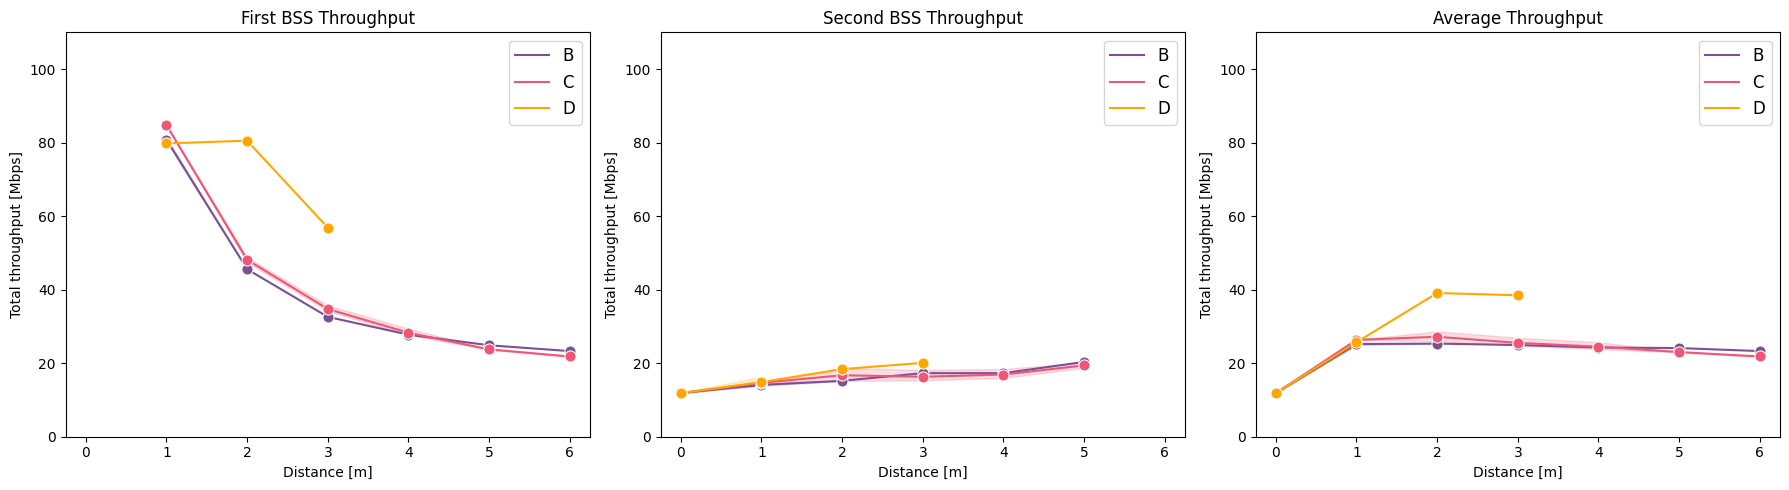

In [6]:
# ----------- Parametry wykresu -----------

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)  # Trzy wykresy w jednym rzędzie
xlabel = "Distance [m]"

# Listy danych i tytułów do iteracji
plot_data = [
    (df0, 'First BSS Throughput'),
    (df1, 'Second BSS Throughput'),
    (df_sum, 'Average Throughput')
]

# ----------- Rysowanie wykresów -----------

for i, (df, title) in enumerate(plot_data):
    sns.lineplot(data=df, x='MLOn', y='throughput', hue='scenario',
                 errorbar=('ci'), markers=True, palette=palette,
                 style='flow' if 'flow' in df.columns else None,
                 ax=axes[i])

    axes[i].tick_params(axis='y', which='both', labelleft=True)
    for line in axes[i].get_lines():
        line.set_markersize(marker_size)

    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(
        handles=handles[1:7],  # Przytnij, jeśli trzeba
        labels=['B', 'C', 'D'],  # Twoje etykiety
        ncol=1,
        fontsize='large'
    )

    axes[i].set(xlabel=xlabel, ylabel='Total throughput [Mbps]')
    axes[i].set_title(title, fontsize='large')
    if i != 2:
        axes[i].set_ylim(0, 110)
    else:
        axes[i].set_ylim(0, 110) #, 225
    axes[i].grid(color='white', linestyle='--', linewidth=0.5)
    axes[i].set_xlim(-0.25, 6.25)

# ----------- Zapis i wyświetlenie -----------

plt.tight_layout()
plt.savefig('dist_thr_flows.svg', bbox_inches='tight')
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_63188\2444023311.py:26: UserWarning: Mismatched number of handles and labels: len(handles) = 6 len(labels) = 4
  axes[i].legend(
C:\Users\Admin\AppData\Local\Temp\ipykernel_63188\2444023311.py:26: UserWarning: Mismatched number of handles and labels: len(handles) = 6 len(labels) = 4
  axes[i].legend(
C:\Users\Admin\AppData\Local\Temp\ipykernel_63188\2444023311.py:26: UserWarning: Mismatched number of handles and labels: len(handles) = 6 len(labels) = 4
  axes[i].legend(


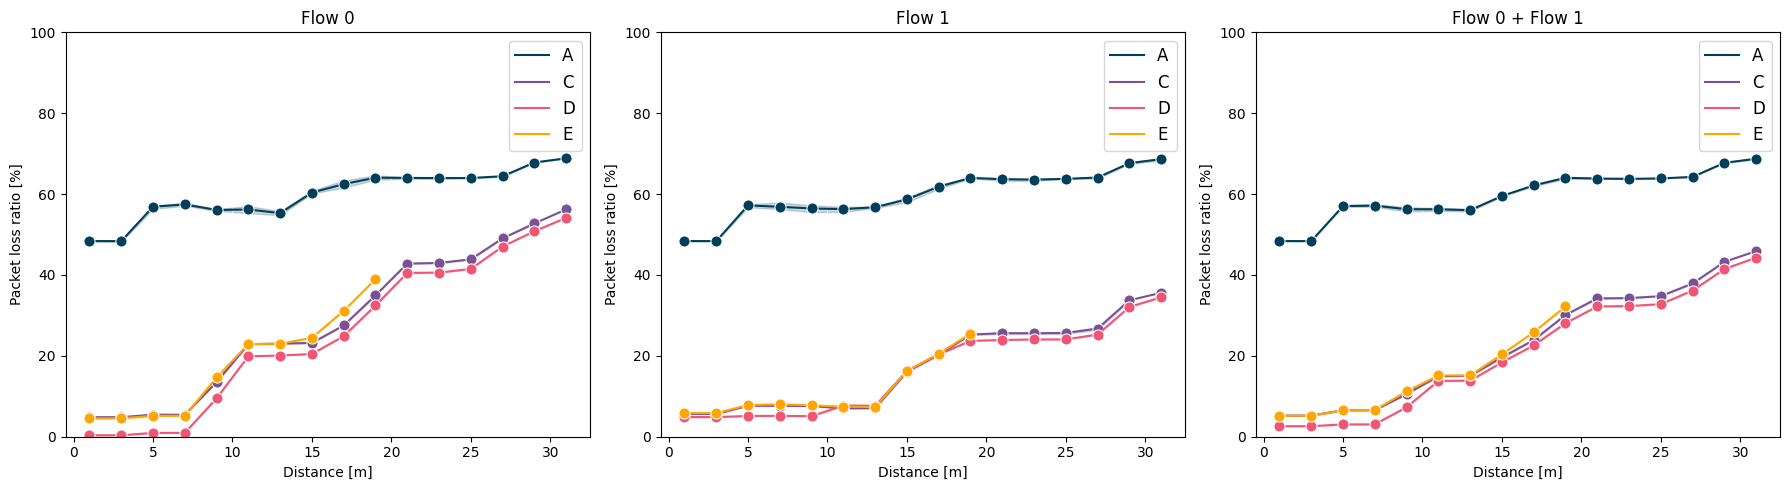

In [27]:
# ----------- Parametry wykresu -----------

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)  # Trzy wykresy w jednym rzędzie
xlabel = "Distance [m]"

# Listy danych i tytułów do iteracji
plot_data = [
    (df0, 'Flow 0'),
    (df1, 'Flow 1'),
    (df_sum, 'Flow 0 + Flow 1')
]

# ----------- Rysowanie wykresów -----------

for i, (df, title) in enumerate(plot_data):
    sns.lineplot(data=df, x='distance', y='loss', hue='scenario',
                 errorbar=('ci'), markers=True, palette=palette,
                 style='flow' if 'flow' in df.columns else None,
                 ax=axes[i])

    axes[i].tick_params(axis='y', which='both', labelleft=True)
    for line in axes[i].get_lines():
        line.set_markersize(marker_size)

    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(
        handles=handles[1:7],  # Przytnij, jeśli trzeba
        labels=['A', 'C', 'D', 'E'],  # Twoje etykiety
        ncol=1,
        fontsize='large'
    )

    axes[i].set(xlabel=xlabel, ylabel='Packet loss ratio [%]')
    axes[i].set_title(title, fontsize='large')
    axes[i].set_ylim(0, 100) 
    axes[i].grid(color='white', linestyle='--', linewidth=0.5)

# ----------- Zapis i wyświetlenie -----------

plt.tight_layout()
plt.savefig('dist_loss_flows.svg', bbox_inches='tight')
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_63188\4261411581.py:26: UserWarning: Mismatched number of handles and labels: len(handles) = 6 len(labels) = 4
  axes[i].legend(
C:\Users\Admin\AppData\Local\Temp\ipykernel_63188\4261411581.py:26: UserWarning: Mismatched number of handles and labels: len(handles) = 6 len(labels) = 4
  axes[i].legend(
C:\Users\Admin\AppData\Local\Temp\ipykernel_63188\4261411581.py:26: UserWarning: Mismatched number of handles and labels: len(handles) = 6 len(labels) = 4
  axes[i].legend(


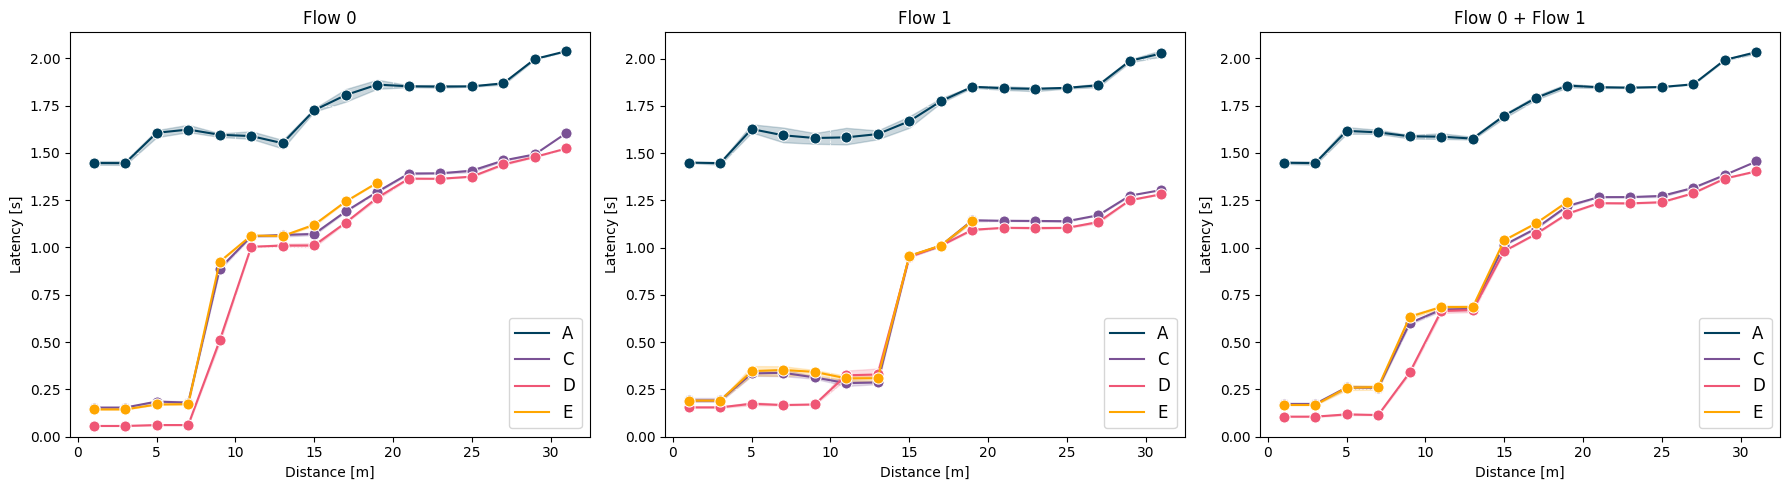

In [28]:
# ----------- Parametry wykresu -----------

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)  # Trzy wykresy w jednym rzędzie
xlabel = "Distance [m]"

# Listy danych i tytułów do iteracji
plot_data = [
    (df0, 'Flow 0'),
    (df1, 'Flow 1'),
    (df_sum, 'Flow 0 + Flow 1')
]

# ----------- Rysowanie wykresów -----------

for i, (df, title) in enumerate(plot_data):
    sns.lineplot(data=df, x='distance', y='latency', hue='scenario',
                 errorbar=('ci'), markers=True, palette=palette,
                 style='flow' if 'flow' in df.columns else None,
                 ax=axes[i])

    axes[i].tick_params(axis='y', which='both', labelleft=True)
    for line in axes[i].get_lines():
        line.set_markersize(marker_size)

    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(
        handles=handles[1:7],  # Przytnij, jeśli trzeba
        labels=['A', 'C', 'D', 'E'],  # Twoje etykiety
        ncol=1,
        fontsize='large'
    )

    axes[i].set(xlabel=xlabel, ylabel='Latency [s]')
    axes[i].set_title(title, fontsize='large')
    axes[i].set_ylim(0) 
    axes[i].grid(color='white', linestyle='--', linewidth=0.5)

# ----------- Zapis i wyświetlenie -----------

plt.tight_layout()
plt.savefig('dist_lat_flows.svg', bbox_inches='tight')
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_63188\1466104044.py:26: UserWarning: Mismatched number of handles and labels: len(handles) = 6 len(labels) = 4
  axes[i].legend(
C:\Users\Admin\AppData\Local\Temp\ipykernel_63188\1466104044.py:26: UserWarning: Mismatched number of handles and labels: len(handles) = 6 len(labels) = 4
  axes[i].legend(
C:\Users\Admin\AppData\Local\Temp\ipykernel_63188\1466104044.py:26: UserWarning: Mismatched number of handles and labels: len(handles) = 6 len(labels) = 4
  axes[i].legend(


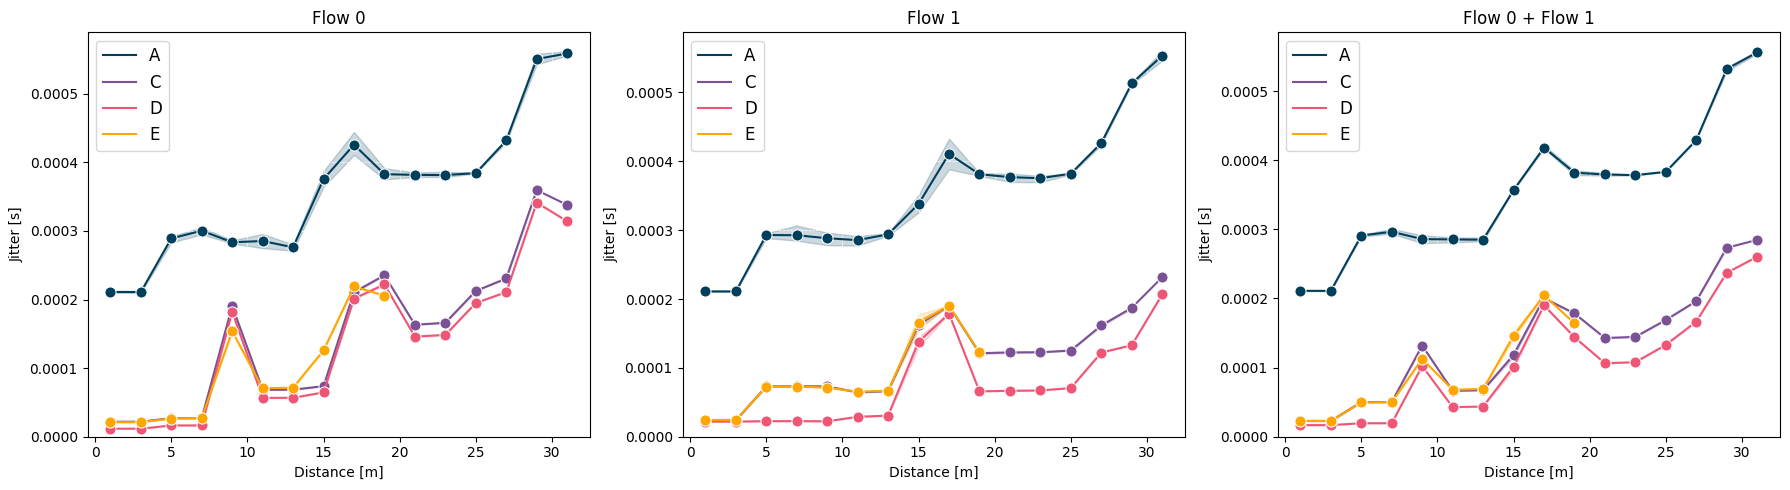

In [29]:
# ----------- Parametry wykresu -----------

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)  # Trzy wykresy w jednym rzędzie
xlabel = "Distance [m]"

# Listy danych i tytułów do iteracji
plot_data = [
    (df0, 'Flow 0'),
    (df1, 'Flow 1'),
    (df_sum, 'Flow 0 + Flow 1')
]

# ----------- Rysowanie wykresów -----------

for i, (df, title) in enumerate(plot_data):
    sns.lineplot(data=df, x='distance', y='jitter', hue='scenario',
                 errorbar=('ci'), markers=True, palette=palette,
                 style='flow' if 'flow' in df.columns else None,
                 ax=axes[i])

    axes[i].tick_params(axis='y', which='both', labelleft=True)
    for line in axes[i].get_lines():
        line.set_markersize(marker_size)

    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(
        handles=handles[1:7],  # Przytnij, jeśli trzeba
        labels=['A', 'C', 'D', 'E'],  # Twoje etykiety
        ncol=1,
        fontsize='large'
    )

    axes[i].set(xlabel=xlabel, ylabel='Jitter [s]')
    axes[i].set_title(title, fontsize='large')
    axes[i].set_ylim(0) 
    axes[i].grid(color='white', linestyle='--', linewidth=0.5)

# ----------- Zapis i wyświetlenie -----------

plt.tight_layout()
plt.savefig('dist_jit_flows.svg', bbox_inches='tight')
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_63188\1403217536.py:10: UserWarning: Mismatched number of handles and labels: len(handles) = 6 len(labels) = 4
  ax.legend(


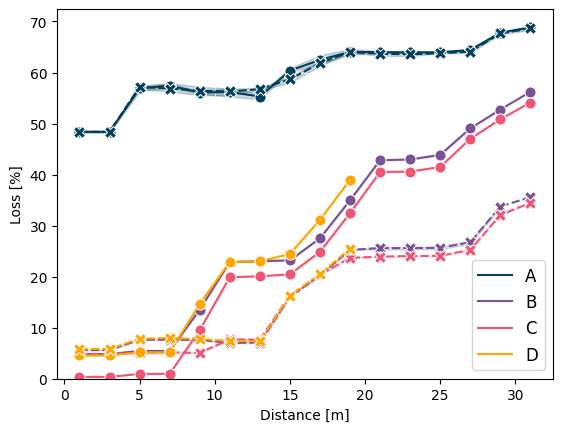

In [30]:
ax = None
plt.grid(color = 'white', linestyle = '--', linewidth = 0.5)

ax = sns.lineplot(data=plot_sum, x='distance', y='loss', hue='scenario', errorbar=('ci'), markers=True, palette=palette, ax=ax, style='flow')
ax.tick_params(axis='y', which='both', labelleft=True)
for line in ax.get_lines():  # Modyfikacja markerów w istniejących liniach
    line.set_markersize(marker_size)

handles, labels = ax.get_legend_handles_labels()
ax.legend(
      handles=handles[1:7],
      labels=['A', 'B', 'C', 'D'],
      ncol=1,              # Liczba kolumn w legendzie
      fontsize='large',   # Rozmiar czcionki
    )
ax.set_ylim(0) 
ax.set(xlabel=xlabel, ylabel='Loss [%]')
plt.savefig('dist_loss.svg', bbox_inches='tight')

In [31]:
plot_sum = plot_sum[plot_sum['latency'] != 0]

C:\Users\Admin\AppData\Local\Temp\ipykernel_63188\1676141539.py:10: UserWarning: Mismatched number of handles and labels: len(handles) = 6 len(labels) = 4
  ax.legend(


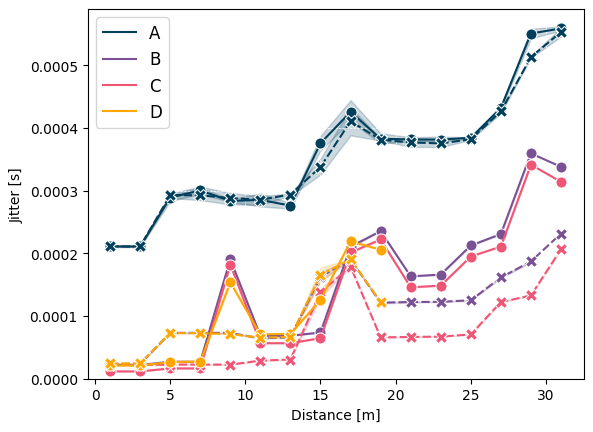

In [32]:
ax = None
plt.grid(color = 'white', linestyle = '--', linewidth = 0.5)

ax = sns.lineplot(data=plot_sum, x='distance', y='jitter', hue='scenario', errorbar=('ci'), markers=True, palette=palette, ax=ax, style='flow')
ax.tick_params(axis='y', which='both', labelleft=True)
for line in ax.get_lines():  # Modyfikacja markerów w istniejących liniach
    line.set_markersize(marker_size)

handles, labels = ax.get_legend_handles_labels()
ax.legend(
      handles=handles[1:7],
      labels=['A', 'B', 'C', 'D'],
      ncol=1,              # Liczba kolumn w legendzie
      fontsize='large',   # Rozmiar czcionki
    )
ax.set_ylim(0) 
ax.set(xlabel=xlabel, ylabel='Jitter [s]')
plt.savefig('dist_jitt.svg', bbox_inches='tight')

C:\Users\Admin\AppData\Local\Temp\ipykernel_63188\713197596.py:10: UserWarning: Mismatched number of handles and labels: len(handles) = 6 len(labels) = 4
  ax.legend(


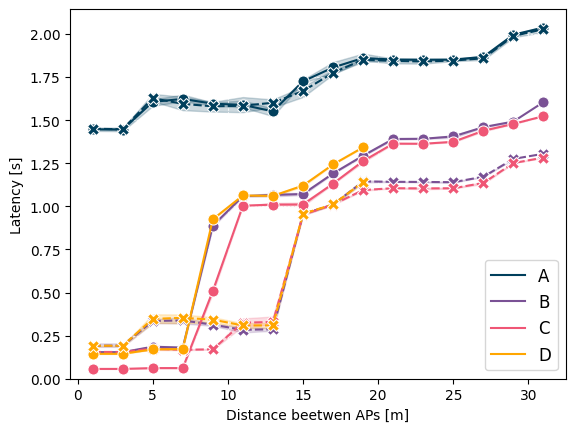

In [33]:
ax = None
plt.grid(color = 'white', linestyle = '--', linewidth = 0.5)

ax = sns.lineplot(data=plot_sum, x='distance', y='latency', hue='scenario', errorbar=('ci'), markers=True, palette=palette, ax=ax, style='flow')
ax.tick_params(axis='y', which='both', labelleft=True)
for line in ax.get_lines():  # Modyfikacja markerów w istniejących liniach
    line.set_markersize(marker_size)

handles, labels = ax.get_legend_handles_labels()
ax.legend(
      handles=handles[1:7],
      labels=['A', 'B', 'C', 'D'],
      ncol=1,              # Liczba kolumn w legendzie
      fontsize='large',   # Rozmiar czcionki
    )
ax.set(xlabel='Distance beetwen APs [m]', ylabel='Latency [s]')
ax.set_ylim(0)  
plt.savefig('dist_lat.svg', bbox_inches='tight')

C:\Users\Admin\AppData\Local\Temp\ipykernel_63188\1614032054.py:12: UserWarning: Mismatched number of handles and labels: len(handles) = 6 len(labels) = 4
  axes[0].legend(
C:\Users\Admin\AppData\Local\Temp\ipykernel_63188\1614032054.py:30: UserWarning: Mismatched number of handles and labels: len(handles) = 6 len(labels) = 4
  axes[1].legend(


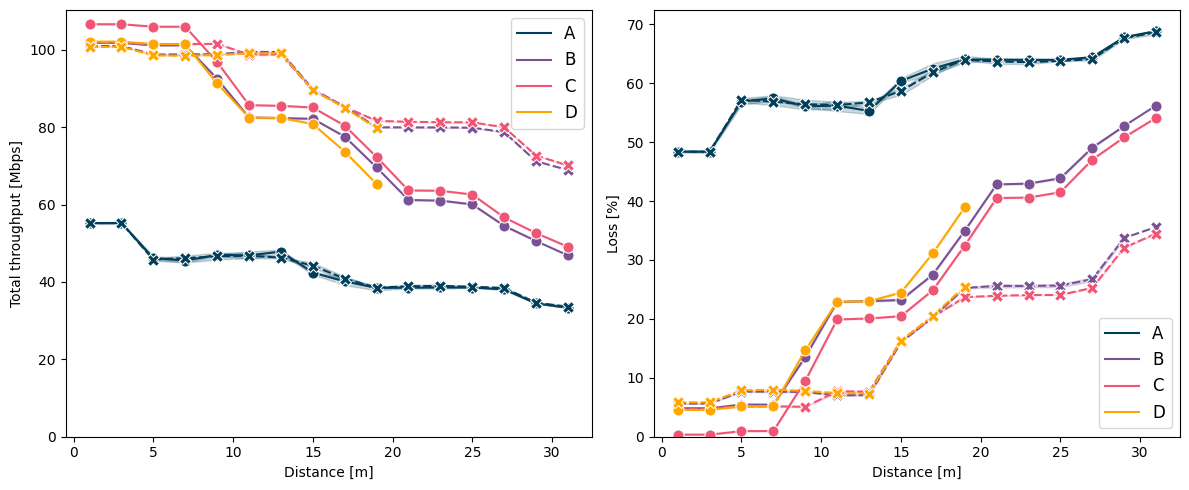

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)  # Dwa wykresy w jednym rzędzie

# Pierwszy wykres - Throughput
sns.lineplot(data=plot_sum, x='distance', y='throughput', hue='scenario', 
             errorbar=('ci'), markers=True, palette=palette, ax=axes[0], style='flow')

axes[0].tick_params(axis='y', which='both', labelleft=True)
for line in axes[0].get_lines():
    line.set_markersize(marker_size)

handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(
      handles=handles[1:7],
      labels=['A', 'B', 'C', 'D'],
      ncol=1,              # Liczba kolumn w legendzie
      fontsize='large',   # Rozmiar czcionki
    )
axes[0].set(xlabel=xlabel, ylabel='Total throughput [Mbps]')
axes[0].grid(color='white', linestyle='--', linewidth=0.5)

# Drugi wykres - Loss
sns.lineplot(data=plot_sum, x='distance', y='loss', hue='scenario', 
             errorbar=('ci'), markers=True, palette=palette, ax=axes[1], style='flow')

axes[1].tick_params(axis='y', which='both', labelleft=True)
for line in axes[1].get_lines():
    line.set_markersize(marker_size)

handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(
      handles=handles[1:7],
      labels=['A', 'B', 'C', 'D'],
      ncol=1,              # Liczba kolumn w legendzie
      fontsize='large',   # Rozmiar czcionki
    )

axes[1].set(xlabel=xlabel, ylabel='Loss [%]')
axes[1].grid(color='white', linestyle='--', linewidth=0.5)
axes[0].set_ylim(0)  # Ustawienie minimalnej wartości osi Y na 0 dla Throughput
axes[1].set_ylim(0)  # Ustawienie minimalnej wartości osi Y na 0 dla Loss
plt.tight_layout()  # Optymalne rozmieszczenie wykresów
plt.savefig('dist_thr_loss.svg', bbox_inches='tight')
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_63188\2306251324.py:12: UserWarning: Mismatched number of handles and labels: len(handles) = 6 len(labels) = 4
  axes[0].legend(
C:\Users\Admin\AppData\Local\Temp\ipykernel_63188\2306251324.py:31: UserWarning: Mismatched number of handles and labels: len(handles) = 6 len(labels) = 4
  axes[1].legend(


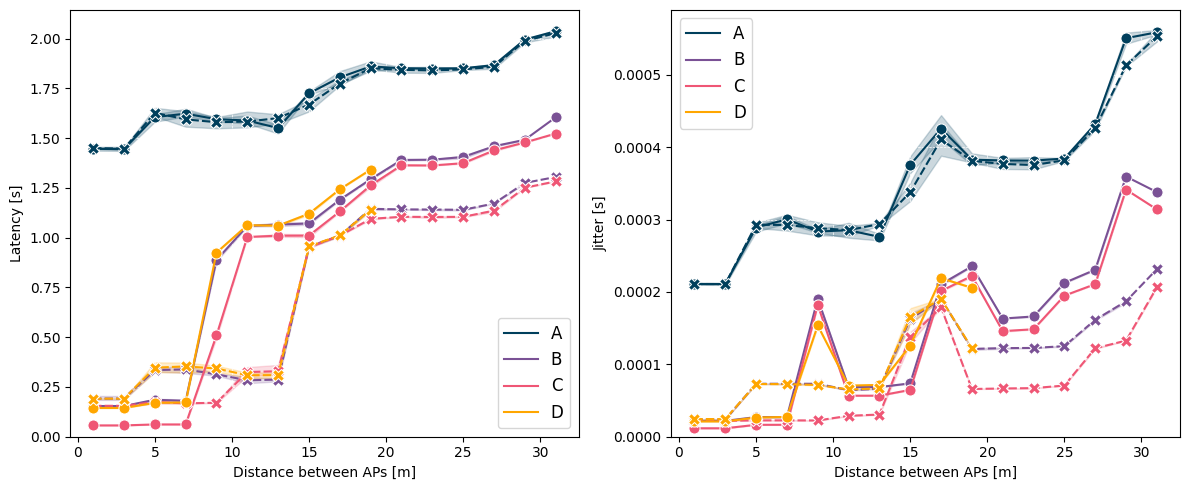

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)  # Dwa wykresy w jednym rzędzie

# Pierwszy wykres - Latency
sns.lineplot(data=plot_sum, x='distance', y='latency', hue='scenario', 
             errorbar=('ci'), markers=True, palette=palette, ax=axes[0], style='flow')

axes[0].tick_params(axis='y', which='both', labelleft=True)
for line in axes[0].get_lines():
    line.set_markersize(marker_size)

handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(
      handles=handles[1:7],
      labels=['A', 'B', 'C', 'D'],
      ncol=1,              # Liczba kolumn w legendzie
      fontsize='large',   # Rozmiar czcionki
    )

axes[0].set(xlabel='Distance between APs [m]', ylabel='Latency [s]')
axes[0].grid(color='white', linestyle='--', linewidth=0.5)

# Drugi wykres - Jitter
sns.lineplot(data=plot_sum, x='distance', y='jitter', hue='scenario', 
             errorbar=('ci'), markers=True, palette=palette, ax=axes[1], style='flow')

axes[1].tick_params(axis='y', which='both', labelleft=True)
for line in axes[1].get_lines():
    line.set_markersize(marker_size)

handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(
      handles=handles[1:7],
      labels=['A', 'B', 'C', 'D'],
      ncol=1,              # Liczba kolumn w legendzie
      fontsize='large',   # Rozmiar czcionki
    )

axes[1].set(xlabel='Distance between APs [m]', ylabel='Jitter [s]')
axes[1].grid(color='white', linestyle='--', linewidth=0.5)
axes[0].set_ylim(0)  # Ustawienie minimalnej wartości osi Y na 0 dla Throughput
axes[1].set_ylim(0)  # Ustawienie minimalnej wartości osi Y na 0 dla Loss
plt.tight_layout()  # Optymalne rozmieszczenie wykresów
plt.savefig('dist_lat_jitter.svg', bbox_inches='tight')
plt.show()
